In [5]:
import numpy as np
import os, glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import datetime
from datetime import timedelta
import seaborn as sb

from matplotlib.colors import Normalize
import matplotlib.ticker as mticker
from pandas import Series, DataFrame
from pylab import rcParams
from netCDF4 import Dataset
from scipy import interpolate
from datetime import date, timedelta

from scipy import stats
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

from dateutil import tz
import time as timemod
from scipy.interpolate import griddata

from global_land_mask import globe

from statsmodels.stats.weightstats import DescrStatsW
import matplotlib as mpl


In [11]:
years  = ['2008', '2010', '2012', '2013']
months = ['06', '07', '08']  # Change this
vals_m = ['300', '300', '400', '400', ]
lat1 = -60  ; lat2 = -30  # Change this
lon1 = -180; lon2 = 180
work_dir = 'libRadtran-2.0.4-compiled-with-extras'
proj = ccrs.PlateCarree(central_longitude=0.0, globe=None) # ccrs.NorthPolarStereo(central_longitude=0.0, globe=None)

if months == ['06', '07', '08']:  # New change to correct figure titles for season
    seas = 'JJA'
elif months == ['01', '02', '12']:
    seas = 'DJF'

## Atmospheric MERRA2 Data, Midlat JJA

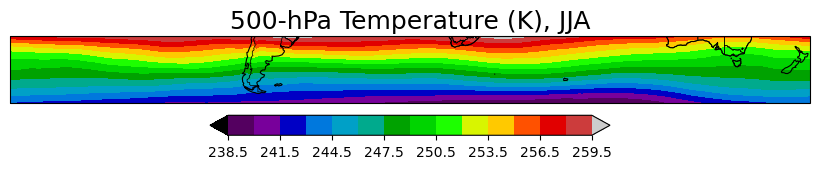

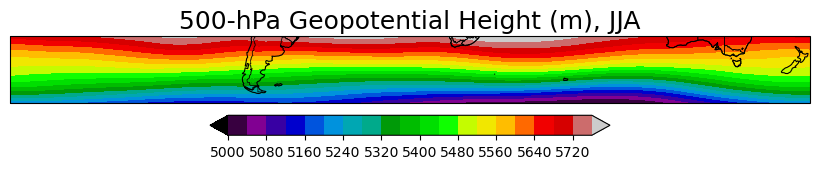

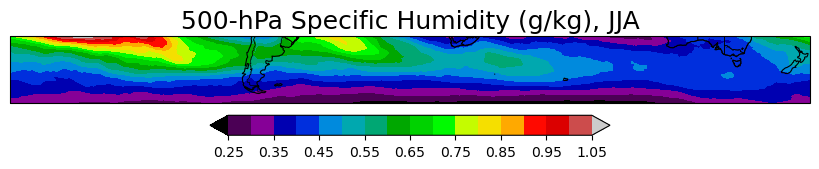

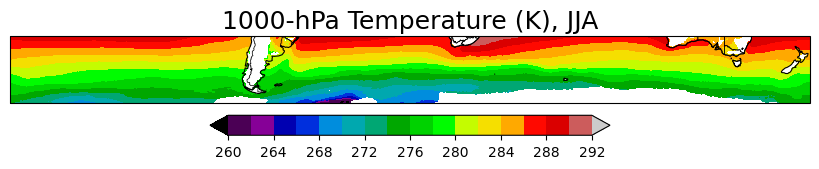

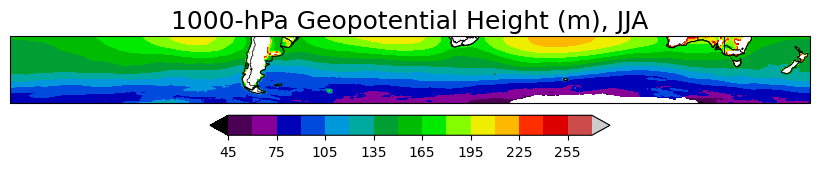

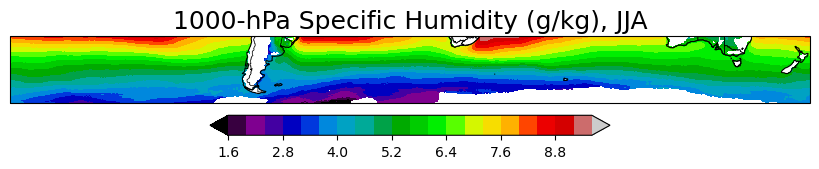

In [12]:
for y, year in enumerate(years): # (['2008']):
    for month in months:  
        dirc_merra = '/data/chchang/Reanalysis/MERRA2/instM_3d_asm_Np/' + year + '/'        
        merra_file = dirc_merra + 'MERRA2_' + vals_m[y] + '.instM_3d_asm_Np.' + year + month + '.nc4'
        if y == 0 and month == months[0]:  # A new change to make the code more general
            merra_lat = Dataset(merra_file).variables['lat'][:]
            merra_lon = Dataset(merra_file).variables['lon'][:]
            merra_P   = Dataset(merra_file).variables['lev'][:]

            id_la = np.where((merra_lat >= lat1) & (merra_lat <= lat2))[0]
            id_lo = np.where((merra_lon >= lon1) & (merra_lon <= lon2))[0]
            
            merra_H   = Dataset(merra_file).variables['H'][:,:,id_la, id_lo]
            merra_T   = Dataset(merra_file).variables['T'][:,:,id_la, id_lo]

            merra_lon = merra_lon[id_lo]
            merra_lat = merra_lat[id_la]
            merra_lon_msh, merra_lat_msh = np.meshgrid(merra_lon, merra_lat)
        else:
            merra_H   = np.concatenate([merra_H, Dataset(merra_file).variables['H'][:,:,id_la, id_lo]], axis=0) 
            merra_T   = np.concatenate([merra_T, Dataset(merra_file).variables['T'][:,:,id_la, id_lo]], axis=0) 
     
    
#####
for y, year in enumerate(years): # (['2008']):
    for month in months:  # ['01']:
        dirc_merra = '/data/chchang/Reanalysis/MERRA2/instM_3d_asm_Np/' + year + '/'        
        merra_file = dirc_merra + 'MERRA2_' + vals_m[y] + '.instM_3d_asm_Np.' + year + month + '.nc4'
        if y == 0 and month == months[0]:  # A new change to make the code more general
            merra_lat = Dataset(merra_file).variables['lat'][:]
            merra_lon = Dataset(merra_file).variables['lon'][:]
            merra_P   = Dataset(merra_file).variables['lev'][:]

            id_la = np.where((merra_lat >= lat1) & (merra_lat <= lat2))[0]
            id_lo = np.where((merra_lon >= lon1) & (merra_lon <= lon2))[0]
            
            merra_QV  = Dataset(merra_file).variables['QV'][:,:,id_la, id_lo]

            merra_lon = merra_lon[id_lo]
            merra_lat = merra_lat[id_la]
            merra_lon_msh, merra_lat_msh = np.meshgrid(merra_lon, merra_lat)
        else:
            merra_QV  = np.concatenate([merra_QV, Dataset(merra_file).variables['QV'][:,:,id_la, id_lo]], axis=0)      
            
##########################            
### Masking oceans:
is_land = globe.is_land(merra_lat_msh, merra_lon_msh)
land    = merra_lat_msh.copy()
land[:] = np.nan
land[is_land == True] = 1.
land[is_land == False] = 0.

# ######
# ###
# fig = plt.figure(figsize=(5,5))
# ax = plt.axes(projection = proj)
# clevs = 1 # np.arange(270, 296, 1)
# csf = ax.contourf(merra_lon, merra_lat, land, clevs, cmap = 'nipy_spectral', extend = 'neither', transform = ccrs.PlateCarree()) #
# ax.coastlines(resolution='110m', linewidth=.8)
# #ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
# ax.add_feature(cfeature.BORDERS, linewidth=.5)
# ax.add_feature(cfeature.STATES, linewidth=.5)
# #cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
# plt.tight_layout(pad=0)
# #plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
# plt.show()


##################################
merra_T[merra_T > 4000]  = np.nan
merra_H[merra_H > 50000] = np.nan
merra_QV[merra_QV > 50000] = np.nan

merra_H_mean  = np.nanmean(merra_H , 0)
merra_T_mean  = np.nanmean(merra_T , 0)
merra_QV_mean = np.nanmean(merra_QV, 0)

merra_H_mean_orig  = merra_H_mean.copy()
merra_T_mean_orig  = merra_T_mean.copy()
merra_QV_mean_orig = merra_QV_mean.copy()


# for i in range(len(merra_P)):
#     merra_T_mean[i,:,:][land == 0.] = np.nan
#     merra_H_mean[i,:,:][land == 0.] = np.nan


####################################
lev = 500
idx_lev = np.where(merra_P == lev)[0][0]

###
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection = proj)
clevs = 20 # np.arange(270, 296, 1)
csf = ax.contourf(merra_lon, merra_lat, merra_T_mean_orig[idx_lev,:,:], clevs, cmap = 'nipy_spectral', extend = 'both', transform = ccrs.PlateCarree()) #
ax.coastlines(resolution='110m', linewidth=.8)
#ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.add_feature(cfeature.STATES, linewidth=.5)
plt.title(str(lev) + '-hPa Temperature (K), ' + seas, fontsize = 18)
cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
plt.tight_layout(pad=0)
#plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
plt.show()

###
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection = proj)
clevs = 20 # np.arange(270, 296, 1)
csf = ax.contourf(merra_lon, merra_lat, merra_H_mean_orig[idx_lev,:,:], clevs, cmap = 'nipy_spectral', extend = 'both', transform = ccrs.PlateCarree()) #
ax.coastlines(resolution='110m', linewidth=.8)
#ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.add_feature(cfeature.STATES, linewidth=.5)
plt.title(str(lev) + '-hPa Geopotential Height (m), ' + seas, fontsize = 18)
cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
plt.tight_layout(pad=0)
#plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
plt.show()

###
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection = proj)
clevs = 20 # np.arange(270, 296, 1)
csf = ax.contourf(merra_lon, merra_lat, 1e3*merra_QV_mean_orig[idx_lev,:,:], clevs, cmap = 'nipy_spectral', extend = 'both', transform = ccrs.PlateCarree()) #
ax.coastlines(resolution='110m', linewidth=.8)
#ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.add_feature(cfeature.STATES, linewidth=.5)
plt.title(str(lev) + '-hPa Specific Humidity (g/kg), ' + seas, fontsize = 18)
cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
plt.tight_layout(pad=0)
#plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
plt.show()


####################################
lev = 1000
idx_lev = np.where(merra_P == lev)[0][0]

###
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection = proj)
clevs = 20 # np.arange(270, 296, 1)
csf = ax.contourf(merra_lon, merra_lat, merra_T_mean_orig[idx_lev,:,:], clevs, cmap = 'nipy_spectral', extend = 'both', transform = ccrs.PlateCarree()) #
ax.coastlines(resolution='110m', linewidth=.8)
#ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.add_feature(cfeature.STATES, linewidth=.5)
plt.title(str(lev) + '-hPa Temperature (K), ' + seas, fontsize = 18)
cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
plt.tight_layout(pad=0)
#plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
plt.show()

###
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection = proj)
clevs = 20 # np.arange(270, 296, 1)
csf = ax.contourf(merra_lon, merra_lat, merra_H_mean_orig[idx_lev,:,:], clevs, cmap = 'nipy_spectral', extend = 'both', transform = ccrs.PlateCarree()) #
ax.coastlines(resolution='110m', linewidth=.8)
#ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.add_feature(cfeature.STATES, linewidth=.5)
plt.title(str(lev) + '-hPa Geopotential Height (m), ' + seas, fontsize = 18)
cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
plt.tight_layout(pad=0)
#plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
plt.show()

###
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection = proj)
clevs = 20 # np.arange(270, 296, 1)
csf = ax.contourf(merra_lon, merra_lat, 1e3*merra_QV_mean_orig[idx_lev,:,:], clevs, cmap = 'nipy_spectral', extend = 'both', transform = ccrs.PlateCarree()) #
ax.coastlines(resolution='110m', linewidth=.8)
#ax.set_extent([lon1, lon2, lat1, lat2], ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linewidth=.5)
ax.add_feature(cfeature.STATES, linewidth=.5)
plt.title(str(lev) + '-hPa Specific Humidity (g/kg), ' + seas, fontsize = 18)
cb = plt.colorbar(csf, shrink=.5, pad=0.03, orientation='horizontal')
plt.tight_layout(pad=0)
#plt.savefig(out_dirc + 'map_' + in_file[:-3] + '.png', dpi=300)
plt.show()

## Average profiles

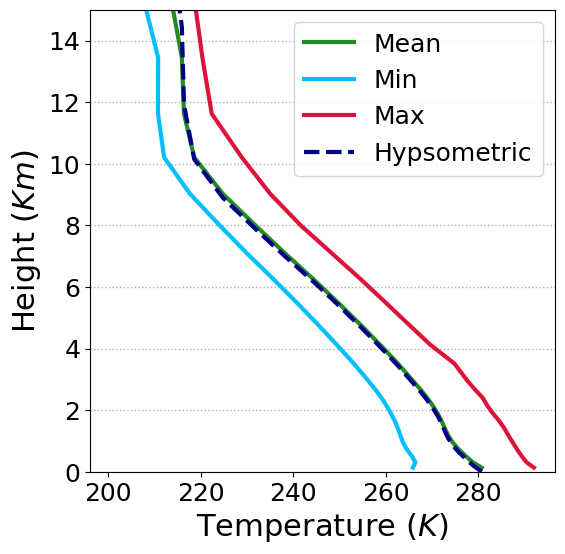

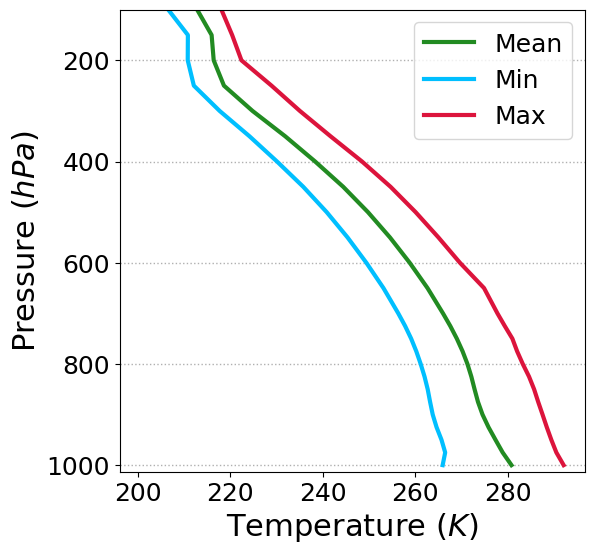

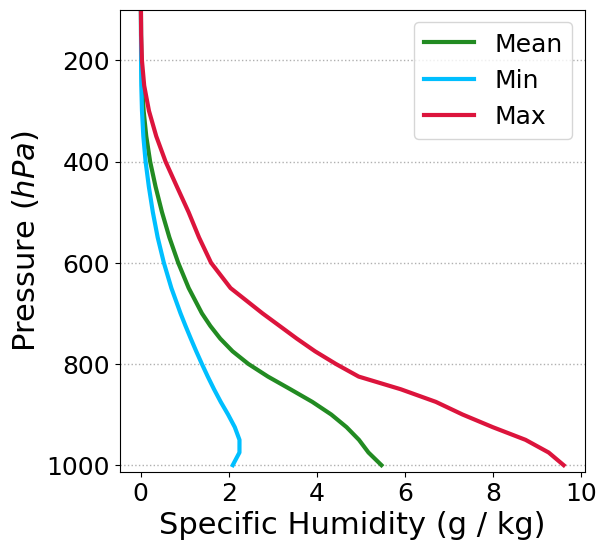

In [13]:
area_weights = np.cos(np.deg2rad(merra_lat_msh))

merra_H_mean_arctic = merra_P.copy()
merra_H_mean_arctic[:] = np.nan
merra_T_mean_arctic = merra_P.copy()
merra_T_mean_arctic[:] = np.nan
merra_QV_mean_arctic = merra_P.copy()
merra_QV_mean_arctic[:] = np.nan
for i in range(len(merra_P)):
    area_weights_nan = area_weights.copy()
    area_weights_nan[np.isnan(merra_H_mean[i,:,:]) == 1] = np.nan
    merra_H_mean_arctic[i] = np.nansum(np.nansum(merra_H_mean[i,:,:] * area_weights_nan, 1), 0)\
                        / np.nansum(np.nansum(area_weights_nan,1),0)
    area_weights_nan = area_weights.copy()
    area_weights_nan[np.isnan(merra_T_mean[i,:,:]) == 1] = np.nan    
    merra_T_mean_arctic[i] = np.nansum(np.nansum(merra_T_mean[i,:,:] * area_weights_nan, 1), 0)\
                        / np.nansum(np.nansum(area_weights_nan,1),0)
    area_weights_nan = area_weights.copy()
    area_weights_nan[np.isnan(merra_QV_mean[i,:,:]) == 1] = np.nan    
    merra_QV_mean_arctic[i] = np.nansum(np.nansum(merra_QV_mean[i,:,:] * area_weights_nan, 1), 0)\
                        / np.nansum(np.nansum(area_weights_nan,1),0)
    
# merra_T_min = np.nanmin(np.nanmin(merra_T_mean,2),1)
merra_T_min = np.nanmean(np.nanmean(np.sort(np.sort(merra_T_mean,2),1)[:,:16,:16],2),1)
merra_T_max = np.nanmax(np.nanmax(merra_T_mean,2),1)
# merra_H_min = np.nanmin(np.nanmin(merra_H_mean,2),1)
merra_H_min = np.nanmean(np.nanmean(np.sort(np.sort(merra_H_mean,2),1)[:,:16,:16],2),1)
merra_H_max = np.nanmax(np.nanmax(merra_H_mean,2),1)
# merra_QV_min = np.nanmin(np.nanmin(merra_QV_mean,2),1)
merra_QV_min = np.nanmean(np.nanmean(np.sort(np.sort(merra_QV_mean,2),1)[:,:16,:16],2),1)
merra_QV_max = np.nanmax(np.nanmax(merra_QV_mean,2),1)

# i_min = np.where(merra_T_mean[0,:,:] == np.nanmin(merra_T_mean[0,:,:]))
# merra_T_min  = merra_T_mean [:, i_min[0][0], i_min[1][0]]
# merra_H_min  = merra_H_mean [:, i_min[0][0], i_min[1][0]]
# merra_QV_min = merra_QV_mean[:, i_min[0][0], i_min[1][0]]

# i_max = np.where(merra_T_mean[0,:,:] == np.nanmax(merra_T_mean[0,:,:]))
# merra_T_max  = merra_T_mean [:, i_max[0][0], i_max[1][0]]
# merra_H_max  = merra_H_mean [:, i_max[0][0], i_max[1][0]]
# merra_QV_max = merra_QV_mean[:, i_max[0][0], i_max[1][0]]

##################
H_hypsometric = ( (1000 / merra_P) ** (1 / 5.257) - 1) * merra_T_mean_arctic / 0.0065

#################
####
fig   = plt.figure(figsize=(6,6))
axis  = plt.axes()
                      
axis.plot(merra_T_mean_arctic, merra_H_mean_arctic / 1000, linewidth= 3, color='forestgreen', label='Mean')
axis.plot(merra_T_min, merra_H_mean_arctic / 1000, linewidth= 3, color='deepskyblue', label='Min')
axis.plot(merra_T_max, merra_H_mean_arctic / 1000, linewidth= 3, color='crimson', label='Max')
axis.plot(merra_T_mean_arctic, H_hypsometric / 1000, '--', linewidth= 3, color='darkblue', label='Hypsometric')
axis.set_ylabel('Height ($Km$)', fontsize = '22')
axis.set_xlabel('Temperature ($K$)', fontsize = '22')
axis.tick_params(axis='both', which='major', labelsize=18)
axis.grid(linestyle=':', axis='y', linewidth=1)
axis.legend(fontsize=18)
#axis.set_ylim([1e-1, 1.5e2])
axis.set_ylim([0, 15])
#axis.set_yscale('log')
plt.show()

####
fig   = plt.figure(figsize=(6,6))
axis  = plt.axes()
                      
axis.plot(merra_T_mean_arctic, merra_P, linewidth= 3, color='forestgreen', label='Mean')
axis.plot(merra_T_min, merra_P, linewidth= 3, color='deepskyblue', label='Min')
axis.plot(merra_T_max, merra_P, linewidth= 3, color='crimson', label='Max')
axis.set_ylabel('Pressure ($hPa$)', fontsize = '22')
axis.set_xlabel('Temperature ($K$)', fontsize = '22')
axis.tick_params(axis='both', which='major', labelsize=18)
axis.grid(linestyle=':', axis='y', linewidth=1)
axis.legend(fontsize=18)
axis.set_ylim([100, 1013])
#axis.set_ylim([1e-5, 1.1e4])
#axis.set_yscale('log')
plt.gca().invert_yaxis()
plt.show()

####
fig   = plt.figure(figsize=(6,6))
axis  = plt.axes()
                      
axis.plot(merra_QV_mean_arctic * 1e3, merra_P, linewidth= 3, color='forestgreen', label='Mean')
axis.plot(merra_QV_min * 1e3, merra_P, linewidth= 3, color='deepskyblue', label='Min')
axis.plot(merra_QV_max * 1e3, merra_P, linewidth= 3, color='crimson', label='Max')
axis.set_ylabel('Pressure ($hPa$)', fontsize = '22')
axis.set_xlabel('Specific Humidity (g / kg)', fontsize = '22')
axis.tick_params(axis='both', which='major', labelsize=18)
axis.grid(linestyle=':', axis='y', linewidth=1)
axis.legend(fontsize=18)
axis.set_ylim([100, 1013])
#axis.set_ylim([1e-5, 1.1e4])
#axis.set_yscale('log')
plt.gca().invert_yaxis()
plt.show()

## Using MERRA2 atmosphere to correct RTM proper profile

In [26]:
# Make sure to change the directory for saving the files. Otherwise, the code overwrites to previous files.
# In this case, I first created a new directory named "CALIPSO_Midlat_SH" on a Linux terminal.
# Then, changed "CALIPSO_Midlat_SH" to "CALIPSO_Midlat_SH_JJA" in this section and anywhere else.

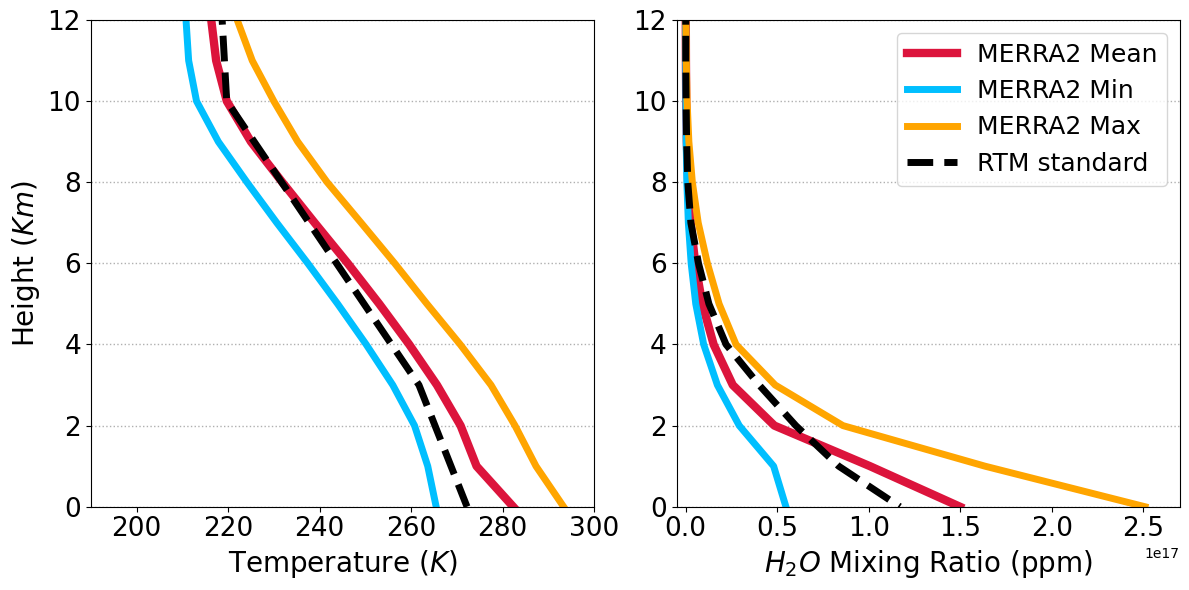

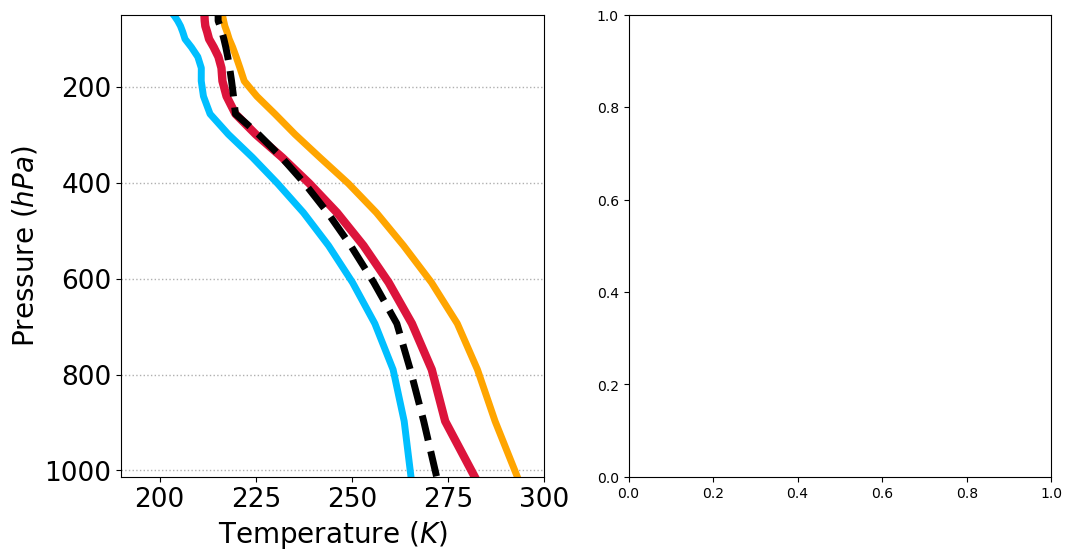

In [27]:
## Just a test
merra_H_mean_arctic_2 = merra_P.copy()
merra_H_mean_arctic_2[:] = np.nan
for i in range(len(merra_P)):
    merra_H_mean_arctic_2[i] = np.average(merra_H_mean[i,:,:], weights=area_weights)
    
################    
k = 1.380650e-23  # Boltzmann constant
start_row = 1
asw = '/home/eerfani/' + work_dir + '/data/atmmod/afglmw.dat'  # change this

df_asw  = pd.read_fwf(asw, delimiter = " ")
np_asw = df_asw[start_row:].to_numpy() 

data = np_asw[:,1]  
data2= np_asw[:,2]

z  = np.array([float(data[i].split()[0]) for i in range(len(data))]) # [km]
p  = np.array([float(data[i].split()[1]) for i in range(len(data))]) # [hPa]
t  = np.array([float(data[i].split()[2]) for i in range(len(data))]) # [K]
rho= np.array([float(data[i].split()[3]) for i in range(len(data))]) # [cm^-3]
h2o= np.array([float(data2[i].split()[1]) for i in range(len(data2))]) # [cm^-3]


####################
# id_trim1 = np.where(merra_T_mean_arctic >= 250)[0][-1]
# id_trim2 = np.where(merra_T_mean_arctic <= 218)[0][0] + 1
# T_trim  = merra_T_mean_arctic[id_trim1:id_trim2]
# H_trim  = merra_H_mean_arctic[id_trim1:id_trim2]

f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_T_mean_arctic, fill_value='extrapolate')
merra_Tmean_intrp = f(z)
f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_T_min, fill_value='extrapolate')
merra_Tmin_intrp = f(z)
f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_T_max, fill_value='extrapolate')
merra_Tmax_intrp = f(z)

f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_P, fill_value='extrapolate')
merra_P_intrp = f(z)

f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_QV_mean_arctic, fill_value='extrapolate')
merra_QVmean_intrp = f(z)
f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_QV_min, fill_value='extrapolate')
merra_QVmin_intrp = f(z)
f     = interpolate.interp1d(merra_H_mean_arctic / 1000, merra_QV_max, fill_value='extrapolate')
merra_QVmax_intrp = f(z)


#############################
def create_atmos_profiles(merra_Tmean_intrp, merra_QVmean_intrp):

    p_new  = p.copy()
    t_new  = t.copy()
    h2o_new  = h2o.copy()

    tmp  = merra_P_intrp[z < 25]
    tmp2 = merra_Tmean_intrp[z < 25]
    tmp3 = merra_QVmean_intrp[z < 25]

    p_new  [z < 25][:-1] = tmp[:-1]
    t_new  [z < 25] = tmp2    

    rho_new = p_new / (k * t_new * 1e4)
    
    tmp3_mr = tmp3 / (1 - tmp3)
    tmp3_ml = tmp3_mr *  rho_new[z < 25]
    h2o_new[z < 25] = tmp3_ml

    ################################
    #c3 = np.array([float(data[i].split()[3]) for i in range(len(data))]) 
    c4 = np.array([float(data[i].split()[4]) for i in range(len(data))]) 
    c5 = np.array([float(data2[i].split()[0]) for i in range(len(data))]) 
#     c6 = np.array([float(data[i].split()[6]) for i in range(len(data))]) 
    c7 = np.array([float(np_asw[i,3])        for i in range(len(data))]) 
    c8 = np.array([float(np_asw[i,4])        for i in range(len(data))])

    z_df      = pd.DataFrame(z      , columns=['z(km)'])
    p_new_df  = pd.DataFrame(p_new  , columns=['p(mb)'])
    t_new_df  = pd.DataFrame(t_new  , columns=['T(K)' ])
    rho_new_df= pd.DataFrame(rho_new, columns=['air(cm-3)'])

    #c3_df    = pd.DataFrame(c3   , columns=['air(cm-3)'])
    c4_df    = pd.DataFrame(c4   , columns=['o3(cm-3)'])
    c5_df    = pd.DataFrame(c5   , columns=['o2(cm-3)'])
#     c6_df    = pd.DataFrame(c6   , columns=['h2o(cm-3)'])
    h2o_new_df= pd.DataFrame(h2o_new, columns=['h2o(cm-3)'])
    c7_df    = pd.DataFrame(c7   , columns=['co2(cm-3)'])
    c8_df    = pd.DataFrame(c8   , columns=['no2(cm-3)'])

    #df = pd.concat([z_df, p_new_df, t_new_df, c3_df, c4_df, c5_df, c6_df, c7_df, c8_df], axis = 1)
    df = pd.concat([z_df, p_new_df, t_new_df, rho_new_df, c4_df, c5_df, h2o_new_df, c7_df, c8_df], axis = 1)
    
    return df

#####
df = create_atmos_profiles(merra_Tmean_intrp, merra_QVmean_intrp)
# Change this:
df.to_csv('/home/eerfani/' + work_dir + '/CALIPSO_Midlat_SH_JJA/afgl_ARC_WIN.dat', index=False, sep=' ', header=False) 
merra_h2o_mean_arctic = df['h2o(cm-3)']
merra_T_mean_arctic_file = df['T(K)']

df = create_atmos_profiles(merra_Tmin_intrp, merra_QVmin_intrp)
# Change this:
df.to_csv('/home/eerfani/' + work_dir + '/CALIPSO_Midlat_SH_JJA/afgl_ARC_WIN_min.dat', index=False, sep=' ', header=False) 
merra_h2o_min_arctic = df['h2o(cm-3)']
merra_T_min_arctic_file = df['T(K)']

df = create_atmos_profiles(merra_Tmax_intrp, merra_QVmax_intrp)
# Change this:
df.to_csv('/home/eerfani/' + work_dir + '/CALIPSO_Midlat_SH_JJA/afgl_ARC_WIN_max.dat', index=False, sep=' ', header=False) 
merra_h2o_max_arctic = df['h2o(cm-3)']
merra_T_max_arctic_file = df['T(K)']


#####################
fig, axis = plt.subplots(1, 2, figsize=(12,6))
i = 0                      
axis[i].plot(merra_T_mean_arctic_file, z, linewidth=6, color='crimson', label='MERRA2 Mean')
axis[i].plot(merra_T_min_arctic_file, z, linewidth=5, color='deepskyblue', label='MERRA2 Min')
axis[i].plot(merra_T_max_arctic_file, z, linewidth=5, color='orange', label='MERRA2 Max')
# axis[i].plot(merra_T_mean_arctic, H_hypsometric / 1000, '--', linewidth= 3, color='darkblue', label='Hypsometric')
axis[i].plot(t, z, '--', linewidth=5, color='k', label='RTM standard')
# axis[i].plot(merra_Tmean_intrp, z, ':', linewidth= 3, color='k', label='MERRA2, interpolated')
axis[i].set_ylabel('Height ($Km$)', fontsize = '20')
axis[i].set_xlabel('Temperature ($K$)', fontsize = '20')
# axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=19)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
#axis[i].set_ylim([1e-1, 1.5e2])
axis[i].set_ylim([0, 12])
axis[i].set_xlim([190, 300])
#axis[i].set_yscale('log')

i = 1                     
axis[i].plot(merra_h2o_mean_arctic, z, linewidth=6, color='crimson', label='MERRA2 Mean')
axis[i].plot(merra_h2o_min_arctic, z, linewidth=5, color='deepskyblue', label='MERRA2 Min')
axis[i].plot(merra_h2o_max_arctic, z, linewidth=5, color='orange', label='MERRA2 Max')
axis[i].plot(h2o, z, '--', linewidth=5, color='k', label='RTM standard')
# axis[i].plot(merra_QVmean_intrp, merra_P_intrp, ':', linewidth= 3, color='k', label='MERRA2, interpolated')
# axis[i].set_ylabel('Pressure ($hPa$)', fontsize = '20')
axis[i].set_xlabel('$H_2O$ Mixing Ratio (ppm)', fontsize = '20')
axis[i].tick_params(axis='both', which='major', labelsize=19)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].legend(fontsize=18, loc='upper right')
axis[i].set_ylim([0, 12])
axis[i].set_xlim([-0.05e17, 2.7e17])

plt.tight_layout(w_pad=1)
plt.show()

fig, axis = plt.subplots(1, 2, figsize=(12,6))
i = 0
axis[i].plot(merra_T_mean_arctic_file, p, linewidth=6, color='crimson', label='MERRA2 Mean')
axis[i].plot(merra_T_min_arctic_file, p, linewidth=5, color='deepskyblue', label='MERRA2 Min')
axis[i].plot(merra_T_max_arctic_file, p, linewidth=5, color='orange', label='MERRA2 Max')
axis[i].plot(t, p, '--', linewidth=5, color='k', label='RTM standard')
# axis[i].plot(merra_Tmean_intrp, merra_P_intrp, ':', linewidth= 3, color='k', label='MERRA2, interpolated')
axis[i].set_ylabel('Pressure ($hPa$)', fontsize = '20')
axis[i].set_xlabel('Temperature ($K$)', fontsize = '20')
axis[i].tick_params(axis='both', which='major', labelsize=19)
axis[i].grid(linestyle=':', axis='y', linewidth=1)
axis[i].set_ylim([50, 1013])
axis[i].set_xlim([190, 300])
axis[i].invert_yaxis()
plt.show()

## Cloud Properties by Satellite

## Median and quartiles calculation

In [28]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [29]:
'''
1) over oceans All IABs (our nominal configuration over oceans with all samples considered)

2) over land IAB > 0.01 sr-1 (our nominal configuration over land; samples with OD < 0.2-0.3 not included to 
avoid larger uncertainties related to larger uncertainties in surface properties than over oceans)

3) over oceans IAB > 0.01 sr-1: samples with OD < 0.2-0.3 not included. The goal is to estimate hom fractions 
over land by deriving a correction factor from the comparison of hom fractions over oceans using All IABS and 
only IAB > 0.01 sr-1.

The *part1*files are for the De-IWC parameterizations, and I am guessing you will use only the files provided 
for all IABs over oceans and the files for land. The *part2* files contain the currently assessed hom-het 
extinction thresholds and resulting hom fractions.
'''

    
# Read csv file and extract variables:
dirc  = './CALIPSO_files/Stats_ascii_files_ocean_allIABs_part1_part2_v1/' # change this
file  = 'Stats_iab000_sea_170235235350_60S30S_08101213_JJA_part1_v1'      # change this
file2 = 'Stats_iab000_sea_170235235350_60S30S_08101213_JJA_part2_v1'      # change this

# Part 1 includes a 2-row header (which can be removed if necessary) and then 16 temperatures x 40 extinction bins
# per temperature = 640 rows. Each row has 7 columns. Temp is now added in the first column. "-9." is a fill value.
df = pd.read_csv(dirc + file, header=1, delimiter='\s+')  # , sep=" ", header=None, error_bad_lines=False) #, sep=' ', skiprows=2)
df = df.replace(-9, 0)# np.NaN)  # replace -9 with NaN
columns = pd.read_csv(dirc + file, delimiter='\s+').columns
df.columns = columns

# Part 2 includes the information related to the hom fraction estimates. After the header, 
# there will be always 16 rows for each of the 16 temperatures and 5 rows.
df2 = pd.read_csv(dirc + file2, delimiter='\s+')  # , sep=" ", header=None, error_bad_lines=False) #, sep=' ', skiprows=2)
df2.columns = ['Tr(K)', '#pixels_1', '#pixels_2', 'log10(ext) hom-het limit (km-1)', 'hom_fraction', 'void', 'void', 'void']


T      = df['Tr'].values
lg_ext = df['log10(ext)'].values
De     = df['De'].values
IWC    = df['IWC'].values
Ni     = df['Ni'].values
pixl   = df['#pixels'].values
# bins   = df['#bin'].values
# IWC[IWC < 0] = np.NaN 

thr_hh = df2['log10(ext) hom-het limit (km-1)'].values
fhom   = df2['hom_fraction'].values
fhom[fhom == -9] = 0

# Temperature (and other variables) intervals
Tr = np.unique(T)[np.isnan(np.unique(T)) == 0]

# Initialize variables:
def initiate(var):
    var = Tr.copy().astype(float)
    var[:] = np.nan
    return var

    
De_het_med  = initiate(Tr)
De_hom_med  = initiate(Tr)
IWC_het_med = initiate(Tr)
IWC_hom_med = initiate(Tr)
Ni_het_med  = initiate(Tr)
Ni_hom_med  = initiate(Tr)
De_het_lq   = initiate(Tr)
De_hom_lq   = initiate(Tr)
IWC_het_lq  = initiate(Tr)
IWC_hom_lq  = initiate(Tr)
Ni_het_lq   = initiate(Tr)
Ni_hom_lq   = initiate(Tr)
De_het_uq   = initiate(Tr)
De_hom_uq   = initiate(Tr)
IWC_het_uq  = initiate(Tr)
IWC_hom_uq  = initiate(Tr)
Ni_het_uq   = initiate(Tr)
Ni_hom_uq   = initiate(Tr)
    

for i in range(len(Tr)):
    
    # Subset the data for each temperature interval:
    id_T = np.where(T == Tr[i])
    De_b     = De[id_T]
    IWC_b    = IWC[id_T]
    Ni_b     = Ni[id_T]
    pixl_b   = pixl[id_T]
    lg_ext_b = lg_ext[id_T]
    
    
    if np.nansum(pixl_b) != 0:
    
        # Find the index of threshold of log(ext):
        if thr_hh[i] == -9:
            # A value of -9 means there was no De maximum and therefore no evidence of hom (all data corresponds to het). 
            De_b_het   = De_b  .copy()
            IWC_b_het  = IWC_b .copy()
            Ni_b_het   = Ni_b  .copy()
            pixl_b_het = pixl_b.copy()

            De_het_lq[i] , De_het_med[i] , De_het_uq[i]  = weighted_quantile(De_b_het,  [0.25, 0.5, 0.75], pixl_b_het)
            IWC_het_lq[i], IWC_het_med[i], IWC_het_uq[i] = weighted_quantile(IWC_b_het, [0.25, 0.5, 0.75], pixl_b_het)
            Ni_het_lq[i] , Ni_het_med[i] , Ni_het_uq[i]  = weighted_quantile(Ni_b_het , [0.25, 0.5, 0.75], pixl_b_het)

        else:
            # When there is a threshold of hom/het:
            id_hh = np.where(lg_ext_b == thr_hh[i])[0][0]
            # Divide the # samples in the threshold data line equally between het and hom categories.
            # Then the threshold De and IWC values will be weighted for both het and hom using these divided sample populations.
            pixl_b[id_hh] = pixl_b[id_hh] // 2

            # Divide the interval into hom and het based on the threshold of log(ext):
            De_b_het   = De_b  [:id_hh+1]
            IWC_b_het  = IWC_b [:id_hh+1]
            Ni_b_het   = Ni_b  [:id_hh+1]
            pixl_b_het = pixl_b[:id_hh+1]

            De_b_hom   = De_b  [id_hh:]
            IWC_b_hom  = IWC_b [id_hh:]
            Ni_b_hom   = Ni_b  [id_hh:]
            pixl_b_hom = pixl_b[id_hh:]

            # Calculate weighted mean and standard deviation:            
            De_het_lq[i] , De_het_med[i] , De_het_uq[i]  = weighted_quantile(De_b_het,  [0.25, 0.5, 0.75], pixl_b_het)
            IWC_het_lq[i], IWC_het_med[i], IWC_het_uq[i] = weighted_quantile(IWC_b_het, [0.25, 0.5, 0.75], pixl_b_het)
            Ni_het_lq[i] , Ni_het_med[i] , Ni_het_uq[i]  = weighted_quantile(Ni_b_het , [0.25, 0.5, 0.75], pixl_b_het)
            De_hom_lq[i] , De_hom_med[i] , De_hom_uq[i]  = weighted_quantile(De_b_hom,  [0.25, 0.5, 0.75], pixl_b_hom)
            IWC_hom_lq[i], IWC_hom_med[i], IWC_hom_uq[i] = weighted_quantile(IWC_b_hom, [0.25, 0.5, 0.75], pixl_b_hom)
            Ni_hom_lq[i] , Ni_hom_med[i] , Ni_hom_uq[i]  = weighted_quantile(Ni_b_hom , [0.25, 0.5, 0.75], pixl_b_hom)            
            

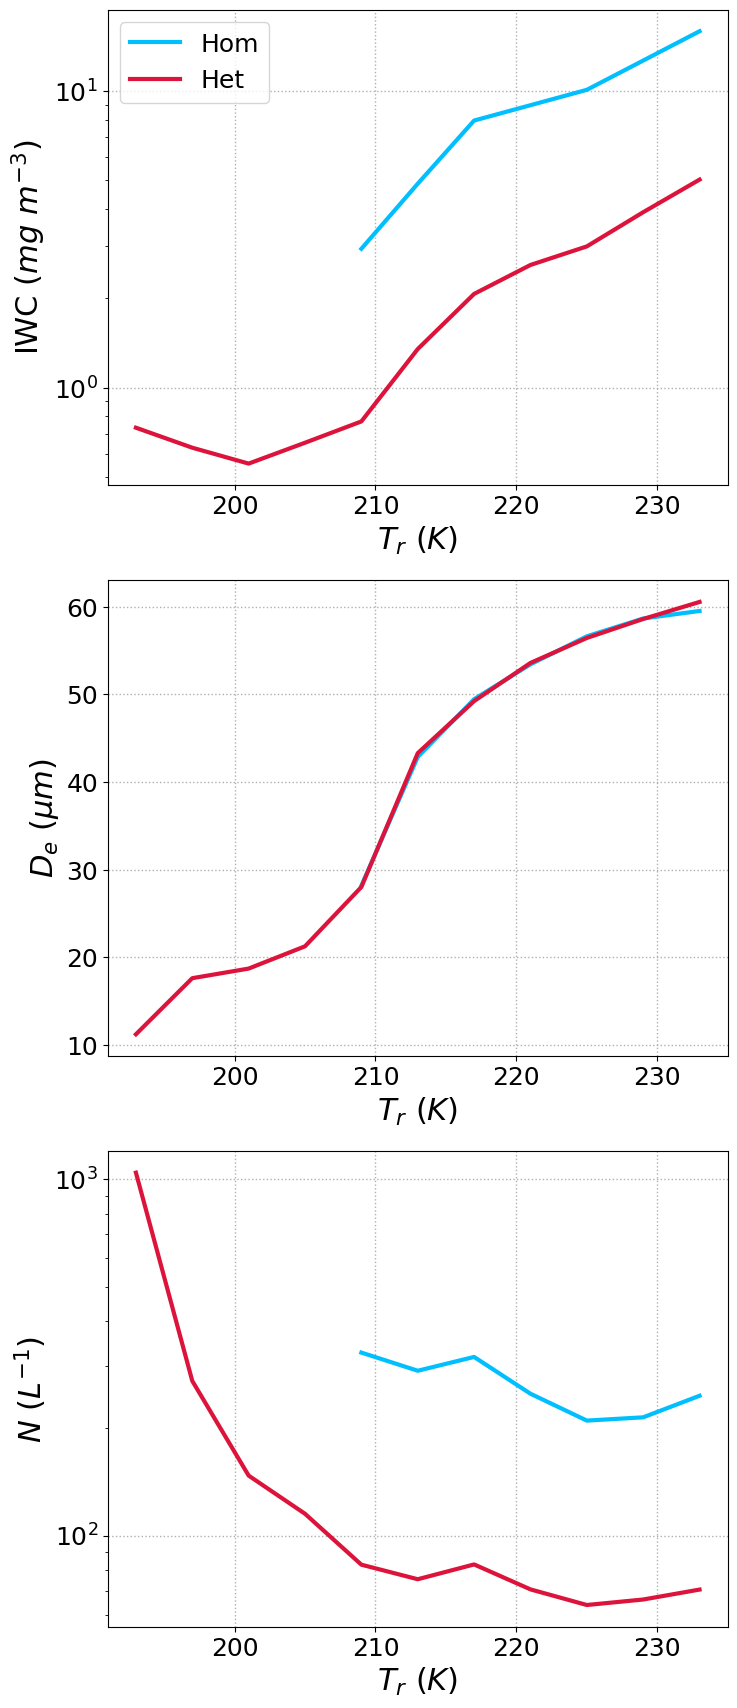

In [30]:
#######
fig, axis = plt.subplots(3, 1, figsize=(8,21))

i = 0
axis[i].plot(Tr, IWC_hom_med, linewidth= 3, color='deepskyblue', label='Hom')
axis[i].plot(Tr, IWC_het_med, linewidth= 3, color='crimson'    , label='Het')
# axis[i].plot(T, IWC    , linewidth= 3, color='darkblue'   , label='All')
axis[i].set_ylabel('IWC ($mg$ $m^{-3}$)', fontsize = '22')
axis[i].set_xlabel('$T_r$ ($K$)', fontsize = '22')
#axis[i].set_yticks([-400, -300, -200, -100, 0])
#axis[i].set_xlim([0, 1000])
#axis[i].set_ylim([-420, 20])
axis[i].tick_params(axis='both', which='major', labelsize=18)
axis[i].grid(linestyle=':', linewidth=1)
axis[i].set_yscale('log')
#axis[i].legend(fontsize = '18', loc='lower right')
#plt.title(str(traj_t)+'-hr Lagrangian Trajectories, JJA 2018-2021', fontsize = 22)
legend = axis[i].legend(fontsize=18)    

i = 1
axis[i].plot(Tr, De_hom_med, linewidth= 3, color='deepskyblue', label='Hom')
axis[i].plot(Tr, De_het_med, linewidth= 3, color='crimson'    , label='Het')
# axis[i].plot(T, De    , linewidth= 3, color='darkblue'   , label='All')
axis[i].set_ylabel('$D_e$ ($μm$)', fontsize = '22')
axis[i].set_xlabel('$T_r$ ($K$)', fontsize = '22')
axis[i].tick_params(axis='both', which='major', labelsize=18)
axis[i].grid(linestyle=':', linewidth=1)

i = 2
axis[i].plot(Tr, Ni_hom_med, linewidth= 3, color='deepskyblue', label='Hom')
axis[i].plot(Tr, Ni_het_med, linewidth= 3, color='crimson'    , label='Het')
# axis[i].plot(T, ni    , linewidth= 3, color='darkblue'   , label='All')
axis[i].set_ylabel('$N$ ($L^{-1}$)', fontsize = '22')
axis[i].set_xlabel('$T_r$ ($K$)', fontsize = '22')
axis[i].tick_params(axis='both', which='major', labelsize=18)
axis[i].grid(linestyle=':', linewidth=1)
axis[i].set_yscale('log')

plt.show()

## Interpolate satellite T to MERRA2 vertical levels

In [43]:
# id_trim1 = np.where(merra_T_mean_arctic >= 250)[0][-1]
# id_trim2 = np.where(merra_T_mean_arctic <= 218)[0][0] + 1
# merra_T_trim  = merra_T_mean_arctic[id_trim1:id_trim2]
# merra_H_trim  = merra_H_mean_arctic[id_trim1:id_trim2]


##### This part has been changed!  Copy and paste this section to your code

id_trim1 = np.where((merra_T_mean_arctic <= 245) & (merra_T_mean_arctic >= 200) & (merra_H_mean_arctic < 10000) & (merra_H_mean_arctic > 2000))
merra_T_trim  = merra_T_mean_arctic[id_trim1]
merra_H_trim  = merra_H_mean_arctic[id_trim1]

T_rev = Tr[::-1]
f_T   = interpolate.interp1d(merra_T_trim, merra_H_trim, fill_value='extrapolate')
H_rev = f_T(T_rev)
H     = H_rev[::-1]


###
id_trim1 = np.where((merra_T_min <= 245) & (merra_T_min >= 200) & (merra_H_min < 10000) & (merra_H_min > 2000))
merra_T_trim  = merra_T_min[id_trim1]
merra_H_trim  = merra_H_min[id_trim1]

T_rev = Tr[::-1]
f_T   = interpolate.interp1d(merra_T_trim, merra_H_trim, fill_value='extrapolate')
H_rev = f_T(T_rev)
H_min = H_rev[::-1]


###
id_trim1 = np.where((merra_T_max <= 245) & (merra_T_max >= 200) & (merra_H_max < 10000) & (merra_H_max > 2000))
merra_T_trim  = merra_T_max[id_trim1]
merra_H_trim  = merra_H_max[id_trim1]

T_rev = Tr[::-1]
f_T   = interpolate.interp1d(merra_T_trim, merra_H_trim, fill_value='extrapolate')
H_rev = f_T(T_rev)
H_max = H_rev[::-1]


# #########
# plt.figure()
# plt.plot(merra_T_mean_arctic, merra_H_mean_arctic)
# plt.plot(Tr, H)
# plt.grid(linestyle=':', linewidth=1)
# plt.ylim(0, 15000)
# plt.show()

# ###
# plt.figure()
# plt.plot(merra_T_min, merra_H_min)
# plt.plot(Tr, H_min)
# plt.grid(linestyle=':', linewidth=1)
# plt.ylim(0, 15000)
# plt.show()

# plt.figure()
# plt.plot(merra_T_max, merra_H_max)
# plt.plot(Tr, H_max)
# plt.grid(linestyle=':', linewidth=1)
# plt.ylim(0, 15000)
# plt.show()


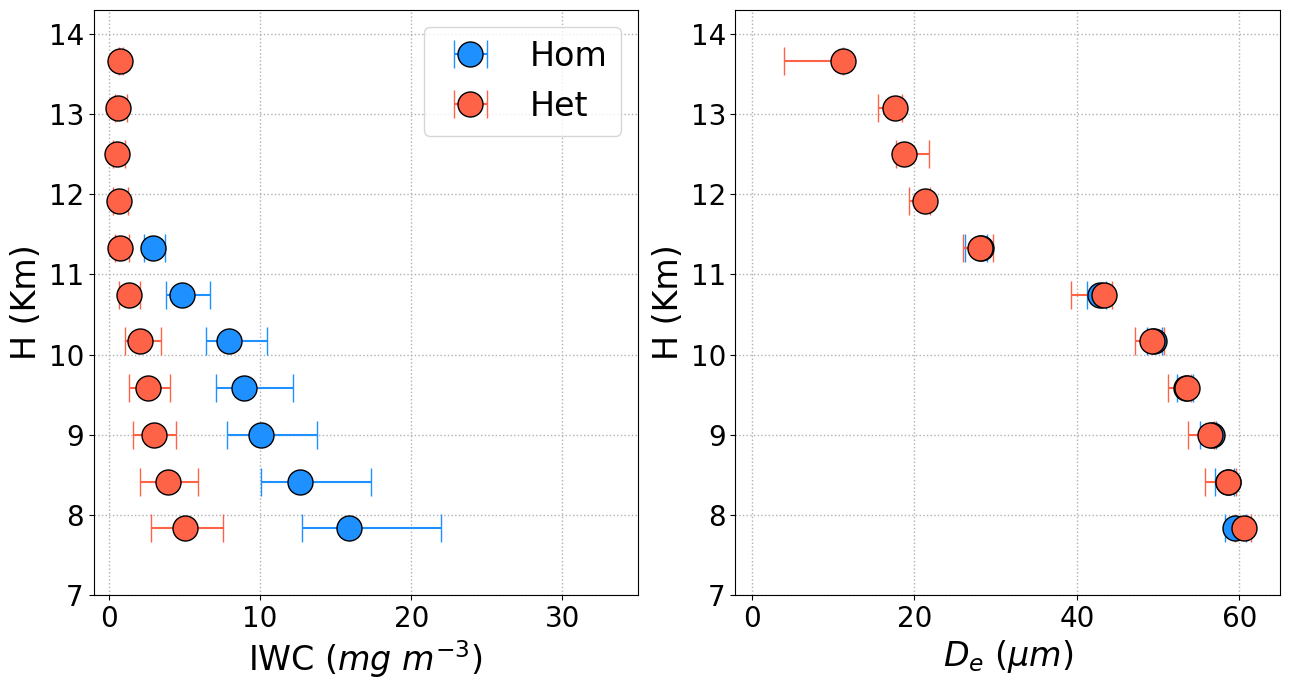

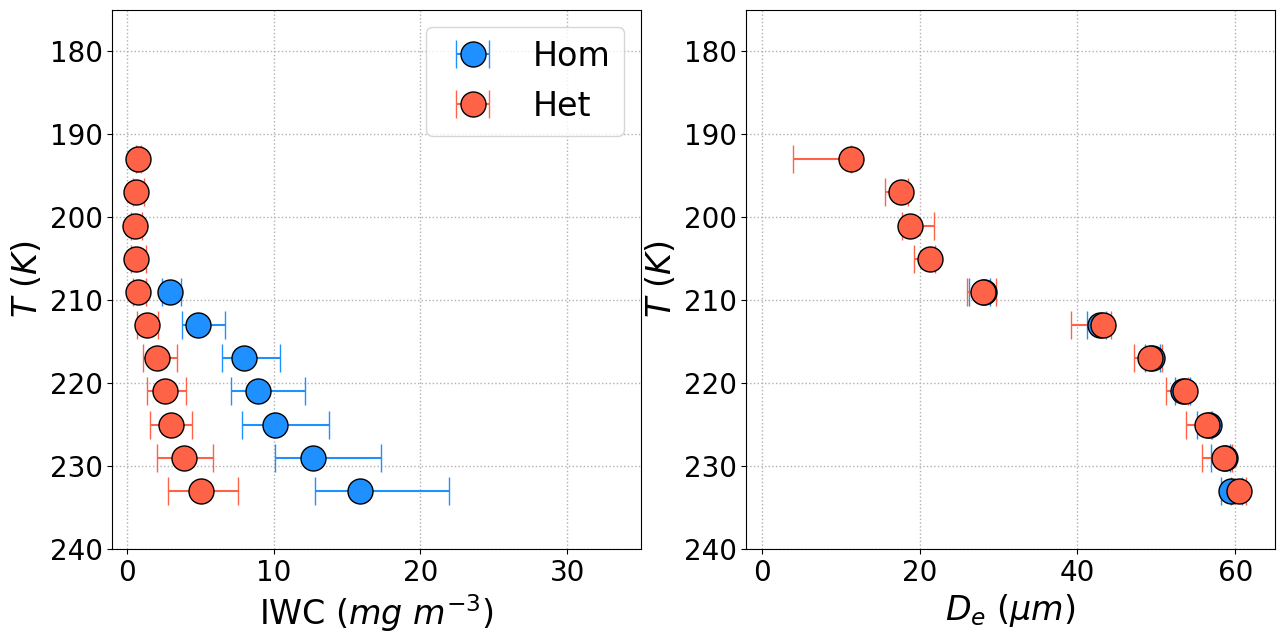

In [22]:
#######
fig, axis = plt.subplots(1, 2, figsize=(13,7))

i = 0
obs3 = axis[i].errorbar(IWC_hom_med, H / 1000, xerr=[IWC_hom_med-IWC_hom_lq ,IWC_hom_uq-IWC_hom_med], markersize=18, \
                        color='dodgerblue', markeredgecolor='k', fmt='o', label='Hom', capsize=10)
obs4 = axis[i].errorbar(IWC_het_med, H / 1000, xerr=[IWC_het_med-IWC_het_lq ,IWC_het_uq-IWC_het_med], markersize=18, \
                        color='tomato', markeredgecolor='k', fmt='o', label='Het', capsize=10)
axis[i].set_xlabel('IWC ($mg$ $m^{-3}$)', fontsize = '24')
axis[i].set_ylabel('H (Km)', fontsize = '24')
axis[i].set_ylim([7, 14.3])
axis[i].set_xlim([-1, 35])
axis[i].tick_params(axis='both', which='major', labelsize=20)
axis[i].grid(linestyle=':', linewidth=1)
# axis[i].set_xscale('log')
legend = axis[i].legend(fontsize=24)    

i = 1
obs3 = axis[i].errorbar(De_hom_med, H / 1000, xerr=[De_hom_med-De_hom_lq ,De_hom_uq-De_hom_med], markersize=18, \
                    color='dodgerblue', markeredgecolor='k', fmt='o', label='Hom', capsize=10)
obs4 = axis[i].errorbar(De_het_med, H / 1000, xerr=[De_het_med-De_het_lq ,De_het_uq-De_het_med], markersize=18, \
                    color='tomato', markeredgecolor='k', fmt='o', label='Het', capsize=10)
axis[i].set_xlabel('$D_e$ ($μm$)', fontsize = '24')
axis[i].set_ylabel('H (Km)', fontsize = '24')
axis[i].tick_params(axis='both', which='major', labelsize=20)
axis[i].grid(linestyle=':', linewidth=1)
axis[i].set_ylim([7, 14.3])
axis[i].set_xlim([-2, 65])

# i = 2
# axis[i].scatter(ni_hom, H / 1000, s=200, edgecolor='k', color='dodgerblue', label='Hom')
# axis[i].scatter(ni_het, H / 1000, s=200, edgecolor='k', color='tomato'    , label='Het')
# # axis[i].scatter(ni    , H / 1000, s=200, edgecolor='k', color='darkblue'   , label='All')
# axis[i].set_xlabel('$N$ ($L^{-1}$)', fontsize = '22')
# axis[i].set_ylabel('H (Km)', fontsize = '22')
# axis[i].tick_params(axis='both', which='major', labelsize=18)
# axis[i].grid(linestyle=':', linewidth=1)
# axis[i].set_xscale('log')
# axis[i].set_ylim([5.5, 17])

plt.tight_layout(w_pad=1)
plt.show()


#######
fig, axis = plt.subplots(1, 2, figsize=(15,7))

i = 0
# axis[i].plot(IWC_hom_median, Tr, color='dodgerblue', linewidth=.5)
# axis[i].plot(IWC_het_median, Tr, color='tomato', linewidth=.5)
# axis[i].scatter(IWC_het_median, Tr, s=200, edgecolor='k', color='tomato'    , label='Het')
obs3 = axis[i].errorbar(IWC_hom_med, Tr, xerr=[IWC_hom_med-IWC_hom_lq ,IWC_hom_uq-IWC_hom_med], markersize=18, \
                        color='dodgerblue', markeredgecolor='k', fmt='o', label='Hom', capsize=10)
obs4 = axis[i].errorbar(IWC_het_med, Tr, xerr=[IWC_het_med-IWC_het_lq ,IWC_het_uq-IWC_het_med], markersize=18, \
                        color='tomato', markeredgecolor='k', fmt='o', label='Het', capsize=10)
axis[i].set_xlabel('IWC ($mg$ $m^{-3}$)', fontsize = '24')
axis[i].set_ylabel('$T$ ($K$)', fontsize = '24')
#axis[i].set_yticks([-400, -300, -200, -100, 0])
axis[i].set_ylim([175, 240])
axis[i].set_xlim([-1, 35])
axis[i].tick_params(axis='both', which='major', labelsize=20)
axis[i].grid(linestyle=':', linewidth=1)
# axis[i].set_xscale('log')
legend = axis[i].legend(fontsize=24)#, loc='lower right')    
axis[i].invert_yaxis()

i = 1
obs3 = axis[i].errorbar(De_hom_med, Tr, xerr=[De_hom_med-De_hom_lq ,De_hom_uq-De_hom_med], markersize=18, \
                    color='dodgerblue', markeredgecolor='k', fmt='o', label='Hom', capsize=10)
obs4 = axis[i].errorbar(De_het_med, Tr, xerr=[De_het_med-De_het_lq ,De_het_uq-De_het_med], markersize=18, \
                    color='tomato', markeredgecolor='k', fmt='o', label='Het', capsize=10)
axis[i].set_xlabel('$D_e$ ($μm$)', fontsize = '24')
axis[i].set_ylabel('$T$ ($K$)', fontsize = '24')
axis[i].tick_params(axis='both', which='major', labelsize=20)
axis[i].grid(linestyle=':', linewidth=1)
axis[i].set_ylim([175, 240])
axis[i].invert_yaxis()
axis[i].set_xlim([-2, 65])

# i = 2
# axis[i].scatter(ni_hom, T, s=200, edgecolor='k', color='dodgerblue', label='Hom')
# axis[i].scatter(ni_het, T, s=200, edgecolor='k', color='tomato'    , label='Het')
# # axis[i].scatter(ni    , T, s=200, edgecolor='k', color='darkblue'   , label='All')
# axis[i].set_xlabel('$N$ ($L^{-1}$)', fontsize = '22')
# axis[i].set_ylabel('$T_r$ ($K$)', fontsize = '22')
# axis[i].tick_params(axis='both', which='major', labelsize=18)
# axis[i].grid(linestyle=':', linewidth=1)
# axis[i].set_xscale('log')
# axis[i].set_ylim([175, 235])
# axis[i].invert_yaxis()

plt.show()

# Method one:
- For each hom and het, the IWC and De “profile” from ~ 5.7 km to 12.1 km is divided into 4 clouds each having a thickness of ~ 1.3 km (representative for cirrus) but with different cloud base and top heights. 
## Create cloud profiles files for use in RTM
### Interpolate profiles to higher resolution

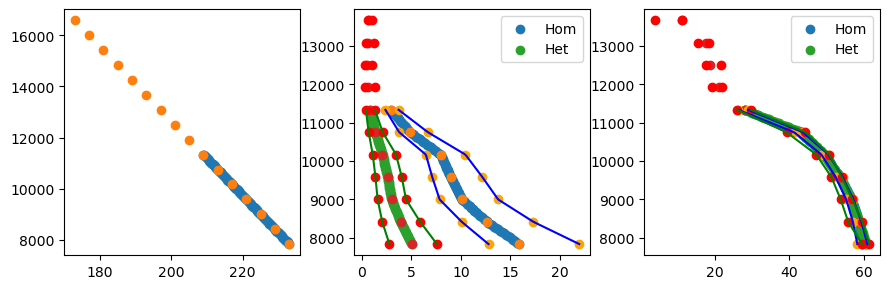

In [23]:
id_q_nonan = np.where(np.isnan(IWC_hom_med) == 0)
H_dn = H[id_q_nonan][-1]
H_up = H[id_q_nonan][0]

def interp_profile(var1, var2):

    id_trim = np.where((var1 <= H_up) & (var1 >= H_dn)) [0]
    var1_trim  = var1[id_trim]
    var2_trim  = var2[id_trim]

    var1_rtm = np.arange(var1_trim[0], var1_trim[-1], - (var1_trim[0] - var1_trim[-1]) / 100)

    f_T   = interpolate.interp1d(var1_trim, var2_trim) #, fill_value='extrapolate')
    var2_rtm = f_T(var1_rtm)
    return var1_rtm, var2_rtm


#####
H_rtm, Tr_rtm = interp_profile(H, Tr)
H_rtm, IWC_hom_med_rtm = interp_profile(H, IWC_hom_med)
H_rtm, IWC_het_med_rtm = interp_profile(H, IWC_het_med)
H_rtm, De_hom_med_rtm  = interp_profile(H, De_hom_med)
H_rtm, De_het_med_rtm  = interp_profile(H, De_het_med)
H_rtm, IWC_hom_lq_rtm  = interp_profile(H, IWC_hom_lq)
H_rtm, IWC_het_lq_rtm  = interp_profile(H, IWC_het_lq)
H_rtm, De_hom_lq_rtm   = interp_profile(H, De_hom_lq)
H_rtm, De_het_lq_rtm   = interp_profile(H, De_het_lq)
H_rtm, IWC_hom_uq_rtm  = interp_profile(H, IWC_hom_uq)
H_rtm, IWC_het_uq_rtm  = interp_profile(H, IWC_het_uq)
H_rtm, De_hom_uq_rtm   = interp_profile(H, De_hom_uq)
H_rtm, De_het_uq_rtm   = interp_profile(H, De_het_uq)


#######
figure, axis = plt.subplots(1, 3, figsize=(9,3))
axis[0].scatter(Tr_rtm, H_rtm)
axis[0].scatter(Tr, H)

###
axis[1].scatter(IWC_hom_med_rtm, H_rtm, label='Hom')
axis[1].scatter(IWC_hom_med, H)
axis[1].scatter(IWC_het_med_rtm, H_rtm, label='Het')
axis[1].scatter(IWC_het_med, H)

axis[1].plot(IWC_hom_uq_rtm, H_rtm, c='b')
axis[1].scatter(IWC_hom_uq, H, c='orange')
axis[1].plot(IWC_hom_lq_rtm, H_rtm, c='b')
axis[1].scatter(IWC_hom_lq, H, c='orange')

axis[1].plot(IWC_het_uq_rtm, H_rtm, c='g')
axis[1].scatter(IWC_het_uq, H, c='r')
axis[1].plot(IWC_het_lq_rtm, H_rtm, c='g')
axis[1].scatter(IWC_het_lq, H, c='r')

axis[1].legend()

###
axis[2].scatter(De_hom_med_rtm, H_rtm, label='Hom')
axis[2].scatter(De_hom_med, H)
axis[2].scatter(De_het_med_rtm, H_rtm, label='Het')
axis[2].scatter(De_het_med, H)

axis[2].plot(De_hom_uq_rtm, H_rtm, c='b')
axis[2].scatter(De_hom_uq, H, c='orange')
axis[2].plot(De_hom_lq_rtm, H_rtm, c='b')
axis[2].scatter(De_hom_lq, H, c='orange')

axis[2].plot(De_het_uq_rtm, H_rtm, c='g')
axis[2].scatter(De_het_uq, H, c='r')
axis[2].plot(De_het_lq_rtm, H_rtm, c='g')
axis[2].scatter(De_het_lq, H, c='r')

axis[2].legend()

plt.tight_layout(w_pad=0)
plt.show()

### Write ice cloud profies to files

[209 213 217 221 225 229 233] [11.33201335 10.74846742 10.1649215   9.58137557  8.99782965  8.41428372
  7.83553923]


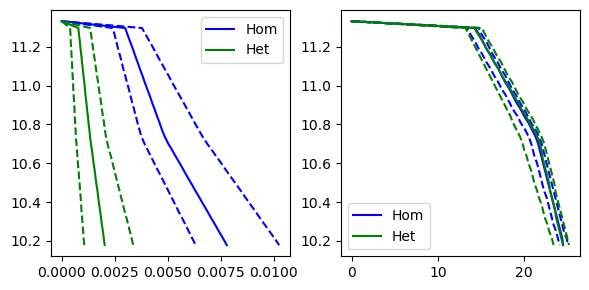

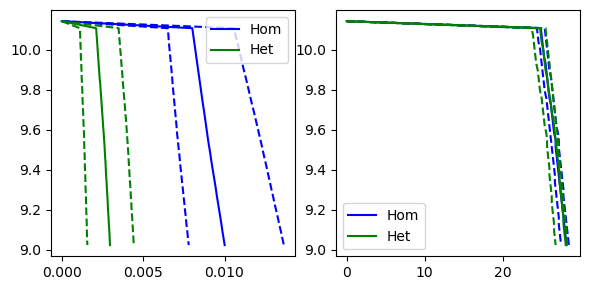

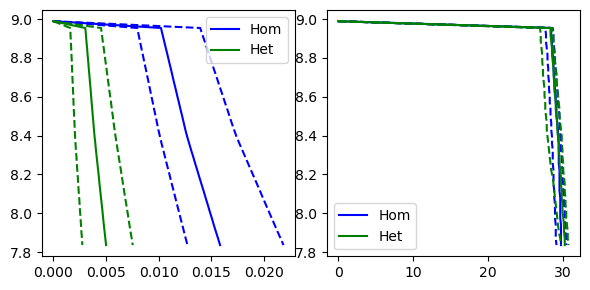

In [42]:
# Something to consider: effective radius allowed range based on Fu [1996]: 9.315 -  65.120 um
# i_de = np.where((De_het_med >= 10 * 2) & (De_het_med <= 65.120 * 2) )   # exact value: 9.315

T_up = 208 # Change this. I personally select this as the coldest temperature that hom data is available.
T_dn = 235

layer_num = 3 # Change this. I try to select the number of clouds in a way to get a cloud thickness of 1100 to 1300 m.


## Proper variables and units for RTM:
H_km_rtm = H_rtm / 1000
IWC_si_hom_med_rtm = IWC_hom_med_rtm / 1000
IWC_si_het_med_rtm = IWC_het_med_rtm / 1000
IWC_si_hom_lq_rtm  = IWC_hom_lq_rtm / 1000
IWC_si_het_lq_rtm  = IWC_het_lq_rtm / 1000
IWC_si_hom_uq_rtm  = IWC_hom_uq_rtm / 1000
IWC_si_het_uq_rtm  = IWC_het_uq_rtm / 1000
Re_hom_med_rtm = De_hom_med_rtm / 2 
Re_het_med_rtm = De_het_med_rtm / 2
Re_hom_lq_rtm  = De_hom_lq_rtm / 2
Re_het_lq_rtm  = De_het_lq_rtm / 2
Re_hom_uq_rtm  = De_hom_uq_rtm / 2
Re_het_uq_rtm  = De_het_uq_rtm / 2

H_km_rtm_print       = np.round(H_km_rtm.copy(), 3)

##### Dividing data into multiple separate "clouds" for use in RTM:

id_trim = np.where((Tr <= T_dn) & (Tr >= T_up)) [0]
Tr_trim = Tr[id_trim]
H_trim  = H[id_trim] / 1000
print(Tr_trim, H_trim)

cint = (len(H_trim) - 1) // layer_num
layer_thick = np.round( (H_trim[0] - H_trim[-1]) / layer_num, 4)

CBH = []

###
def prepare_var_print(var, decimal):
    out = np.ndarray(len(H_km_rtm_print_intv), dtype=object)
    out[0] = int(0)
    out[1:] = np.round(var.copy(), decimal)
    return out

###
nn = layer_num
count = H_trim[0]
for i in range(layer_num):#(0,len(H_trim) - 1, cint):
    id_intv = np.where((H_km_rtm_print <= count) & (H_km_rtm_print >= count - layer_thick))[0]
    
    # Select variables for a specific "cloud":
    H_km_rtm_print_intv = H_km_rtm_print[id_intv]
    IWC_si_hom_med_rtm_intv = IWC_si_hom_med_rtm[id_intv]
    IWC_si_het_med_rtm_intv = IWC_si_het_med_rtm[id_intv]
    IWC_si_hom_lq_rtm_intv  = IWC_si_hom_lq_rtm[id_intv]
    IWC_si_het_lq_rtm_intv  = IWC_si_het_lq_rtm[id_intv]
    IWC_si_hom_uq_rtm_intv  = IWC_si_hom_uq_rtm[id_intv]
    IWC_si_het_uq_rtm_intv  = IWC_si_het_uq_rtm[id_intv]
    Re_hom_med_rtm_intv = Re_hom_med_rtm[id_intv]
    Re_het_med_rtm_intv = Re_het_med_rtm[id_intv]
    Re_hom_lq_rtm_intv  = Re_hom_lq_rtm[id_intv]
    Re_het_lq_rtm_intv  = Re_het_lq_rtm[id_intv]
    Re_hom_uq_rtm_intv  = Re_hom_uq_rtm[id_intv]
    Re_het_uq_rtm_intv  = Re_het_uq_rtm[id_intv]
    
    ## Calculate mid-point profiles
    IWC_si_hom_med_rtm_intv_mid = (IWC_si_hom_med_rtm_intv[1:] + IWC_si_hom_med_rtm_intv[:-1]) / 2    
    IWC_si_het_med_rtm_intv_mid = (IWC_si_het_med_rtm_intv[1:] + IWC_si_het_med_rtm_intv[:-1]) / 2    
    IWC_si_hom_lq_rtm_intv_mid  = (IWC_si_hom_lq_rtm_intv[1:]  + IWC_si_hom_lq_rtm_intv[:-1])  / 2    
    IWC_si_het_lq_rtm_intv_mid  = (IWC_si_het_lq_rtm_intv[1:]  + IWC_si_het_lq_rtm_intv[:-1])  / 2    
    IWC_si_hom_uq_rtm_intv_mid  = (IWC_si_hom_uq_rtm_intv[1:]  + IWC_si_hom_uq_rtm_intv[:-1])  / 2    
    IWC_si_het_uq_rtm_intv_mid  = (IWC_si_het_uq_rtm_intv[1:]  + IWC_si_het_uq_rtm_intv[:-1])  / 2    
    Re_hom_med_rtm_intv_mid = (Re_hom_med_rtm_intv[1:] + Re_hom_med_rtm_intv[:-1]) / 2    
    Re_het_med_rtm_intv_mid = (Re_het_med_rtm_intv[1:] + Re_het_med_rtm_intv[:-1]) / 2    
    Re_hom_lq_rtm_intv_mid  = (Re_hom_lq_rtm_intv[1:]  + Re_hom_lq_rtm_intv[:-1])  / 2    
    Re_het_lq_rtm_intv_mid  = (Re_het_lq_rtm_intv[1:]  + Re_het_lq_rtm_intv[:-1])  / 2    
    Re_hom_uq_rtm_intv_mid  = (Re_hom_uq_rtm_intv[1:]  + Re_hom_uq_rtm_intv[:-1])  / 2    
    Re_het_uq_rtm_intv_mid  = (Re_het_uq_rtm_intv[1:]  + Re_het_uq_rtm_intv[:-1])  / 2    
    
    # Prepare variables to be written in a txt file:
    IWC_si_hom_med_rtm_intv_mid_print = prepare_var_print(IWC_si_hom_med_rtm_intv_mid, 5)
    IWC_si_het_med_rtm_intv_mid_print = prepare_var_print(IWC_si_het_med_rtm_intv_mid, 5)
    IWC_si_hom_lq_rtm_intv_mid_print  = prepare_var_print(IWC_si_hom_lq_rtm_intv_mid, 5)
    IWC_si_het_lq_rtm_intv_mid_print  = prepare_var_print(IWC_si_het_lq_rtm_intv_mid, 5)
    IWC_si_hom_uq_rtm_intv_mid_print  = prepare_var_print(IWC_si_hom_uq_rtm_intv_mid, 5)
    IWC_si_het_uq_rtm_intv_mid_print  = prepare_var_print(IWC_si_het_uq_rtm_intv_mid, 5)
    Re_hom_med_rtm_intv_mid_print = prepare_var_print(Re_hom_med_rtm_intv_mid, 1)
    Re_het_med_rtm_intv_mid_print = prepare_var_print(Re_het_med_rtm_intv_mid, 1)
    Re_hom_lq_rtm_intv_mid_print  = prepare_var_print(Re_hom_lq_rtm_intv_mid, 1)
    Re_het_lq_rtm_intv_mid_print  = prepare_var_print(Re_het_lq_rtm_intv_mid, 1)    
    Re_hom_uq_rtm_intv_mid_print  = prepare_var_print(Re_hom_uq_rtm_intv_mid, 1)
    Re_het_uq_rtm_intv_mid_print  = prepare_var_print(Re_het_uq_rtm_intv_mid, 1)    
    
    CBH.append(H_km_rtm_print_intv[-1])
            
    ###
    figure, axis = plt.subplots(1, 2, figsize=(6,3))
    
    ### Write to file
    H_pd   = pd.DataFrame(H_km_rtm_print_intv               , columns=['z (km)'])
    IWC_pd = pd.DataFrame(IWC_si_hom_med_rtm_intv_mid_print, columns=['IWC (g/m^-3)'])
    Re_pd  = pd.DataFrame(Re_hom_med_rtm_intv_mid_print    , columns=['R_eff (um)'])
    df     = pd.concat([H_pd, IWC_pd, Re_pd], axis=1)
    np.savetxt(r'../../' + work_dir + '/CALIPSO_Midlat_SH_JJA/IC_hom_med_' + str(nn) + '.DAT', df.values, delimiter=' ', fmt= '%s')#'%d')   
#     print(np.sum(df.isnull().values))

    axis[0].plot(IWC_pd, H_pd, label='Hom', c='b')
    axis[1].plot(Re_pd, H_pd, label='Hom', c='b')

    H_pd   = pd.DataFrame(H_km_rtm_print_intv               , columns=['z (km)'])
    IWC_pd = pd.DataFrame(IWC_si_hom_uq_rtm_intv_mid_print, columns=['IWC (g/m^-3)'])
    Re_pd  = pd.DataFrame(Re_hom_uq_rtm_intv_mid_print    , columns=['R_eff (um)'])
    df     = pd.concat([H_pd, IWC_pd, Re_pd], axis=1)
    np.savetxt(r'../../' + work_dir + '/CALIPSO_Midlat_SH_JJA/IC_hom_uq_' + str(nn) + '.DAT', df.values, delimiter=' ', fmt= '%s')#'%d')   

    axis[0].plot(IWC_pd, H_pd, '--', c='b')
    axis[1].plot(Re_pd, H_pd, '--', c='b')
    
    H_pd   = pd.DataFrame(H_km_rtm_print_intv               , columns=['z (km)'])
    IWC_pd = pd.DataFrame(IWC_si_hom_lq_rtm_intv_mid_print, columns=['IWC (g/m^-3)'])
    Re_pd  = pd.DataFrame(Re_hom_lq_rtm_intv_mid_print    , columns=['R_eff (um)'])
    df     = pd.concat([H_pd, IWC_pd, Re_pd], axis=1)
    np.savetxt(r'../../' + work_dir + '/CALIPSO_Midlat_SH_JJA/IC_hom_lq_' + str(nn) + '.DAT', df.values, delimiter=' ', fmt= '%s')#'%d')   

    axis[0].plot(IWC_pd, H_pd, '--', c='b')
    axis[1].plot(Re_pd, H_pd, '--', c='b')

    H_pd   = pd.DataFrame(H_km_rtm_print_intv               , columns=['z (km)'])
    IWC_pd = pd.DataFrame(IWC_si_het_med_rtm_intv_mid_print, columns=['IWC (g/m^-3)'])
    Re_pd  = pd.DataFrame(Re_het_med_rtm_intv_mid_print    , columns=['R_eff (um)'])
    df     = pd.concat([H_pd, IWC_pd, Re_pd], axis=1)
    np.savetxt(r'../../' + work_dir + '/CALIPSO_Midlat_SH_JJA/IC_het_med_' + str(nn) + '.DAT', df.values, delimiter=' ', fmt= '%s')#'%d')   

    axis[0].plot(IWC_pd, H_pd, label='Het', c='g')
    axis[1].plot(Re_pd, H_pd, label='Het', c='g')

    H_pd   = pd.DataFrame(H_km_rtm_print_intv               , columns=['z (km)'])
    IWC_pd = pd.DataFrame(IWC_si_het_uq_rtm_intv_mid_print, columns=['IWC (g/m^-3)'])
    Re_pd  = pd.DataFrame(Re_het_uq_rtm_intv_mid_print    , columns=['R_eff (um)'])
    df     = pd.concat([H_pd, IWC_pd, Re_pd], axis=1)
    np.savetxt(r'../../' + work_dir + '/CALIPSO_Midlat_SH_JJA/IC_het_uq_' + str(nn) + '.DAT', df.values, delimiter=' ', fmt= '%s')#'%d')   

    axis[0].plot(IWC_pd, H_pd, '--', c='g')
    axis[1].plot(Re_pd, H_pd, '--', c='g')

    H_pd   = pd.DataFrame(H_km_rtm_print_intv               , columns=['z (km)'])
    IWC_pd = pd.DataFrame(IWC_si_het_lq_rtm_intv_mid_print, columns=['IWC (g/m^-3)'])
    Re_pd  = pd.DataFrame(Re_het_lq_rtm_intv_mid_print    , columns=['R_eff (um)'])
    df     = pd.concat([H_pd, IWC_pd, Re_pd], axis=1)
    np.savetxt(r'../../' + work_dir + '/CALIPSO_Midlat_SH_JJA/IC_het_lq_' + str(nn) + '.DAT', df.values, delimiter=' ', fmt= '%s')#'%d')   
        
    axis[0].plot(IWC_pd, H_pd, '--', c='g')
    axis[1].plot(Re_pd, H_pd, '--', c='g')
    axis[0].legend()
    axis[1].legend()
    plt.tight_layout(w_pad=0)
    plt.show() 

    ######
    count -= layer_thick
    nn -= 1
    
CBH = np.array(CBH)

## Plotting the outputs of RTM
## Function to calculate cloud radiative effect

In [ ]:
def extract_irradiance_solar(level, out):
    df_out = pd.read_fwf(out, delimiter = " ", header=None)
    thermal_hom_toa_d_c = ( float(df_out.iloc[level][1]) + float(df_out.iloc[level][2]) ) / 1000
    thermal_hom_toa_u_c = float(df_out.iloc[level][3]) / 1000
    return thermal_hom_toa_d_c, thermal_hom_toa_u_c


def calc_CREs(file_hom, file_nocld):

    #### TOA
    out   = '/home/eerfani/' + work_dir + '/CALIPSO_Midlat_SH_JJA/' + file_hom  # change this
    thermal_hom_toa_d_c, thermal_hom_toa_u_c = extract_irradiance(1, out)

    out_cs   = '/home/eerfani/' + work_dir + '/CALIPSO_Midlat_SH_JJA/' + file_nocld  # change this
    thermal_hom_toa_d_cs, thermal_hom_toa_u_cs = extract_irradiance(1, out_cs)

    #### Sfc
    thermal_hom_sfc_d_c, thermal_hom_sfc_u_c = extract_irradiance(0, out)

    thermal_hom_sfc_d_cs, thermal_hom_sfc_u_cs = extract_irradiance(0, out_cs)

    #### CRE
    cre_toa_hom = (thermal_hom_toa_d_c - thermal_hom_toa_u_c) - (thermal_hom_toa_d_cs - thermal_hom_toa_u_cs)
    cre_sfc_hom = (thermal_hom_sfc_d_c - thermal_hom_sfc_u_c) - (thermal_hom_sfc_d_cs - thermal_hom_sfc_u_cs)

    cre_hom = cre_toa_hom - cre_sfc_hom
    
    return cre_toa_hom, cre_sfc_hom, cre_hom

## Analyzing outputs of median clouds

In [139]:


###

### Go to destination directory:
dirc = '/home/eerfani/CCT/RTM/'  # change this
os.chdir(dirc)
cloud_number = 4  # change this

cre_toa_hom = np.arange(cloud_number).astype(float)
cre_toa_hom[:] = np.nan
cre_sfc_hom = np.arange(cloud_number).astype(float)
cre_sfc_hom[:] = np.nan
cre_atm_hom = np.arange(cloud_number).astype(float)
cre_atm_hom[:] = np.nan
cre_toa_het = np.arange(cloud_number).astype(float)
cre_toa_het[:] = np.nan
cre_sfc_het = np.arange(cloud_number).astype(float)
cre_sfc_het[:] = np.nan
cre_atm_het = np.arange(cloud_number).astype(float)
cre_atm_het[:] = np.nan

for i in range(len(cre_atm_hom)):
    
    file_nocld = 'UVSPEC_REPTR_THERM_nocld_arct_LAND_baum_mar_hz.OUT'  # change this
    file_hom = 'UVSPEC_REPTR_THERM_hom_med' + str(i+1) + '_arct_LAND_baum_mar_hz.OUT'  # change this
    file_het = 'UVSPEC_REPTR_THERM_het_med' + str(i+1) + '_arct_LAND_baum_mar_hz.OUT'  # change this

    cre_toa_hom[i], cre_sfc_hom[i], cre_atm_hom[i] = calc_CREs(file_hom, file_nocld)
    cre_toa_het[i], cre_sfc_het[i], cre_atm_het[i] = calc_CREs(file_het, file_nocld)

## Analyzing outputs of upper quartile clouds

In [140]:
cre_toa_hom_uq = np.arange(cloud_number).astype(float)
cre_toa_hom_uq[:] = np.nan
cre_sfc_hom_uq = np.arange(cloud_number).astype(float)
cre_sfc_hom_uq[:] = np.nan
cre_atm_hom_uq = np.arange(cloud_number).astype(float)
cre_atm_hom_uq[:] = np.nan
cre_toa_het_uq = np.arange(cloud_number).astype(float)
cre_toa_het_uq[:] = np.nan
cre_sfc_het_uq = np.arange(cloud_number).astype(float)
cre_sfc_het_uq[:] = np.nan
cre_atm_het_uq = np.arange(cloud_number).astype(float)
cre_atm_het_uq[:] = np.nan

for i in range(len(cre_atm_hom_uq)):
    
    file_nocld = 'UVSPEC_REPTR_THERM_nocld_arct_LAND_baum_mar_hz.OUT'  # change this
    file_hom = 'UVSPEC_REPTR_THERM_hom_uq' + str(i+1) + '_arct_LAND_baum_mar_hz.OUT'  # change this
    file_het = 'UVSPEC_REPTR_THERM_het_uq' + str(i+1) + '_arct_LAND_baum_mar_hz.OUT'  # change this

    cre_toa_hom_uq[i], cre_sfc_hom_uq[i], cre_atm_hom_uq[i] = calc_CREs(file_hom, file_nocld)
    cre_toa_het_uq[i], cre_sfc_het_uq[i], cre_atm_het_uq[i] = calc_CREs(file_het, file_nocld) 

## Analyzing outputs of lower quartile clouds

In [141]:
cre_toa_hom_lq = np.arange(cloud_number).astype(float)
cre_toa_hom_lq[:] = np.nan
cre_sfc_hom_lq = np.arange(cloud_number).astype(float)
cre_sfc_hom_lq[:] = np.nan
cre_atm_hom_lq = np.arange(cloud_number).astype(float)
cre_atm_hom_lq[:] = np.nan
cre_toa_het_lq = np.arange(cloud_number).astype(float)
cre_toa_het_lq[:] = np.nan
cre_sfc_het_lq = np.arange(cloud_number).astype(float)
cre_sfc_het_lq[:] = np.nan
cre_atm_het_lq = np.arange(cloud_number).astype(float)
cre_atm_het_lq[:] = np.nan

for i in range(len(cre_atm_hom_lq)):
    
    file_nocld = 'UVSPEC_REPTR_THERM_nocld_arct_LAND_baum_mar_hz.OUT'  # change this
    file_hom = 'UVSPEC_REPTR_THERM_hom_lq' + str(i+1) + '_arct_LAND_baum_mar_hz.OUT'  # change this
    file_het = 'UVSPEC_REPTR_THERM_het_lq' + str(i+1) + '_arct_LAND_baum_mar_hz.OUT'  # change this

    cre_toa_hom_lq[i], cre_sfc_hom_lq[i], cre_atm_hom_lq[i] = calc_CREs(file_hom, file_nocld)
    cre_toa_het_lq[i], cre_sfc_het_lq[i], cre_atm_het_lq[i] = calc_CREs(file_het, file_nocld)

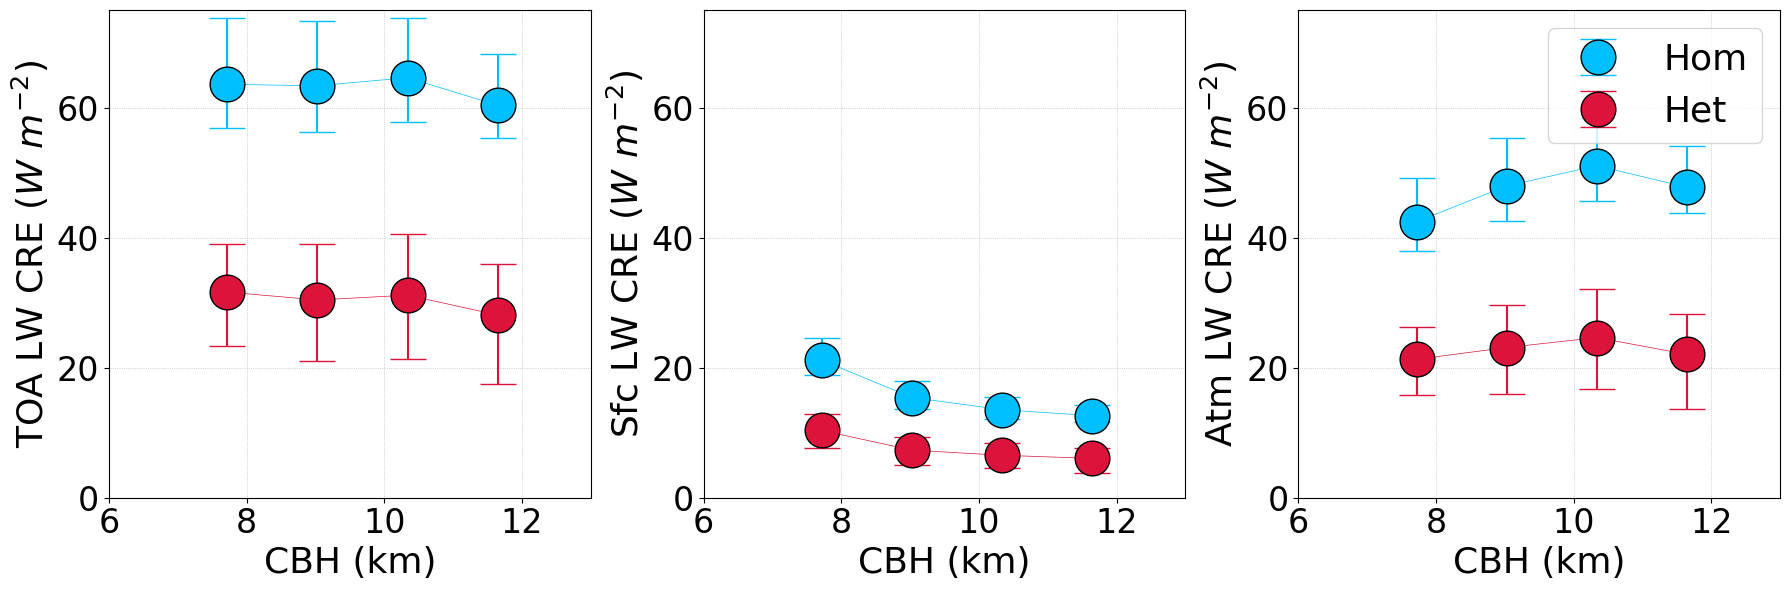

In [260]:
major_ticks = np.arange(0, 80, 20)

cc = np.arange(1,5)
if CBH[0] > CBH[-1]:
    CBH = CBH[::-1]

    
CBH2 = []
thickness = 1.310

for i in range(len(CBH)):
    if i == 0:
        CBH2.append(CBH[0])
    else:
        CBH2.append(CBH2[-1] + thickness)

    
#####################
fig, axis = plt.subplots(1, 3, figsize=(18,6))
i = 0
axis[i].errorbar(CBH2, cre_toa_hom, yerr=[cre_toa_hom-cre_toa_hom_lq ,cre_toa_hom_uq-cre_toa_hom], markersize=25, \
                        color='deepskyblue', markeredgecolor='k', fmt='o', label='Hom', capsize=13)
axis[i].errorbar(CBH2, cre_toa_het, yerr=[cre_toa_het-cre_toa_het_lq ,cre_toa_het_uq-cre_toa_het], markersize=25, \
                        color='crimson'   , markeredgecolor='k', fmt='o', label='Het', capsize=13)
axis[i].plot(CBH2, cre_toa_hom, color='deepskyblue', linewidth=.5)
axis[i].plot(CBH2, cre_toa_het, color='crimson', linewidth=.5)
axis[i].set_ylabel('TOA LW CRE ($W$ $m^{-2}$)', fontsize=26)
axis[i].set_xlabel('CBH (km)', fontsize=26)
# axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=24)
axis[i].grid(linestyle=':', linewidth=.5)
# axis[i].legend(fontsize=22)
axis[i].set_ylim([0, 75])
axis[i].set_xlim([6, 13])
axis[i].set_yticks(major_ticks)

i = 1                      
axis[i].errorbar(CBH2, cre_sfc_hom, yerr=[cre_sfc_hom-cre_sfc_hom_lq ,cre_sfc_hom_uq-cre_sfc_hom], markersize=25, \
                        color='deepskyblue', markeredgecolor='k', fmt='o', label='Hom', capsize=13)
axis[i].errorbar(CBH2, cre_sfc_het, yerr=[cre_sfc_het-cre_sfc_het_lq ,cre_sfc_het_uq-cre_sfc_het], markersize=25, \
                        color='crimson'   , markeredgecolor='k', fmt='o', label='Het', capsize=13)
axis[i].plot(CBH2, cre_sfc_hom, color='deepskyblue', linewidth=.5)
axis[i].plot(CBH2, cre_sfc_het, color='crimson', linewidth=.5)
axis[i].set_ylabel('Sfc LW CRE ($W$ $m^{-2}$)', fontsize=26)
axis[i].set_xlabel('CBH (km)', fontsize=26)
# axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=24)
axis[i].grid(linestyle=':', linewidth=.5)
# axis[i].legend(fontsize=22)
axis[i].set_ylim([0, 75])
axis[i].set_xlim([6, 13])
axis[i].set_yticks(major_ticks)

i = 2                      
axis[i].errorbar(CBH2, cre_atm_hom, yerr=[cre_atm_hom-cre_atm_hom_lq ,cre_atm_hom_uq-cre_atm_hom], markersize=25, \
                        color='deepskyblue', markeredgecolor='k', fmt='o', label='Hom', capsize=13)
axis[i].errorbar(CBH2, cre_atm_het, yerr=[cre_atm_het-cre_atm_het_lq ,cre_atm_het_uq-cre_atm_het], markersize=25, \
                        color='crimson'   , markeredgecolor='k', fmt='o', label='Het', capsize=13)
axis[i].plot(CBH2, cre_atm_hom, color='deepskyblue', linewidth=.5)
axis[i].plot(CBH2, cre_atm_het, color='crimson', linewidth=.5)
axis[i].set_ylabel('Atm LW CRE ($W$ $m^{-2}$)', fontsize=26)
axis[i].set_xlabel('CBH (km)', fontsize=26)
# axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=24)
axis[i].grid(linestyle=':', linewidth=.5)
axis[i].legend(fontsize=26)
axis[i].set_ylim([0, 75])
axis[i].set_xlim([6, 13])
axis[i].set_yticks(major_ticks)
# axis[i].set_yticklabels([0, '', 20, '', 40, '', 60])


plt.tight_layout(w_pad=1)
plt.show()

# This plot is just for illustration. Your final result will definitely be different!